# Load a trained model

In [12]:
from keras.models import load_model
model = load_model('whale.flukes.4250_classes.weights.best.hdf5')

target_size = (150, 150)

from keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def path_to_tensor(img_path, target_size):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size)
    # convert PIL.Image.Image type to 3D tensor with shape (size, size, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, size, size, colors) and return 4D tensor
    return np.expand_dims(x, axis=0)

def get_whale_id(generator, predicted_index):
    return [key for key, value in generator.class_indices.items() if value == predicted_index][0]

def display_image(path):
    if path is None:
        return
    
    img = cv2.imread(path)
   
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

# Classify test images

In [13]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1. / 255)

batch_size = 128
workes = 8

test_generator = test_datagen.flow_from_directory(
    "data/test",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', shuffle=False)

Found 8836 images belonging to 4250 classes.


In [ ]:
score = model.evaluate_generator(
    generator=test_generator)

print("Loss: ", score[0], "Accuracy: ", score[1])

scores = model.predict_generator(
    generator=test_generator)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_generator.classes, list(map(lambda x: np.argmax(x), scores)))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
plt.imshow(cnf_matrix, interpolation='none')
plt.colorbar()
plt.show()

# Classify a single new_whale image

Input image


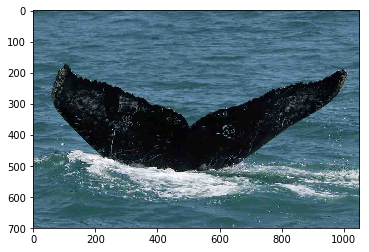

Predicted index: 3246
Predicted whale id: w_c390258
Top 5 indexes and probabilities
(3246, 3295, 4249, 4248, 4247)
[1.000000e+00 7.004352e-18 0.000000e+00 0.000000e+00 0.000000e+00]

Top predicted whale images
train/522d185e.jpg


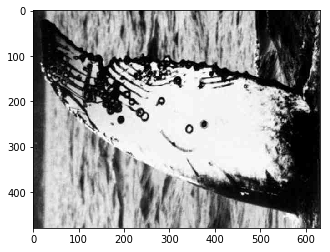

In [15]:
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import cv2
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
    
classes = model.output.shape[1]

# new whales
file = 'fa2b1d93.jpg' 
file = 'f6968c37.jpg'
file = 'f17f76c3.jpg'

# labeled whales
# aa1569e8.jpg w_f22f3e3
# file = 'aa1569e8.jpg'

# eb1bcb6c.jpg w_987a36f
file = 'eb1bcb6c.jpg'
# fbf1c9d5.jpg,w_b7d5069
file = 'fbf1c9d5.jpg'

input_img_path = f'train/{file}'
img = path_to_tensor(input_img_path, target_size)
img = preprocess_input(img)
print('Input image')
display_image(input_img_path)

result = model.predict(img)
predicted_index = np.argmax(result)
print(f'Predicted index: {predicted_index}')
whale_id = get_whale_id(test_generator, predicted_index)

print(f'Predicted whale id: {whale_id}')

print('Top 5 indexes and probabilities')
_, sorted_classes = zip(*sorted(zip(result[0], range(classes)), reverse=True))
probs = np.array(result[0])
print(sorted_classes[:5])
print(probs[np.array(sorted_classes[:5])])

df = pd.read_csv("train.csv", header = 0)
df = df[df.Id == whale_id]

print('\nTop predicted whale images')

for file in df.Image.values:
    predicated_image_path = f'train/{file}'
    print(predicated_image_path)
    display_image(predicated_image_path)


# Predict known new_whale images

In [ ]:
import pandas as pd
import pathlib
import shutil
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

df = pd.read_csv("train.csv", header = 0)

df = df[df.Id == 'new_whale']

dst_dir = './data/predict/new_whale'

pathlib.Path(dst_dir).mkdir(parents=True, exist_ok=True)

for idx, file in enumerate(df.Image):
    shutil.copy(f'./train/{file}', dst_dir)

datagen = ImageDataGenerator(rescale=1. / 255)

new_whale_generator = datagen.flow_from_directory(
    "data/predict",
    target_size=target_size,
    batch_size=128,
    class_mode=None, 
    shuffle=False)

new_whale_scores = model.predict_generator(
    generator=new_whale_generator,
    workers=8)

np.save('new_whale_scores', new_whale_scores)

# Infer labels of final test whale set

In [10]:
import pandas as pd
import pathlib
import shutil
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale=1. / 255)

final_generator = datagen.flow_from_directory(
    "data/final",
    target_size=target_size,
    batch_size=1,
    class_mode=None, 
    shuffle=False)

Found 15610 images belonging to 1 classes.


In [11]:
final_whale_scores = model.predict_generator(
    generator=final_generator,
    workers=1, 
    verbose=1)

np.save('final_whale_scores.one-worker', final_whale_scores)

15610/15610 [==============================] - 760s 49ms/step


# For testing

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    "data/train",
    target_size=target_size,
    batch_size=128,
    class_mode=None, 
    shuffle=False)

In [ ]:
test_scores = model.predict_generator(
    generator=test_generator,
    workers=1, 
    verbose=1)

# Review prediction results
# What My Deep Model Doesn't Know...

http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html

Reviewing labels of 1 top predictions
Predicting: test/0a7c5291.jpg


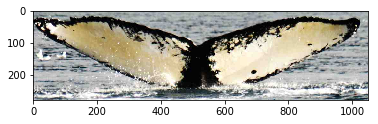

Top predictions:
[(3874, 0.90762913), (2796, 0.06398572), (467, 0.0075034634), (4210, 0.003476679), (2931, 0.0027213919)]
Original labels: ['w_e98432b', 'w_a6a7dbf', 'w_1d17e8c', 'w_fdcfcea', 'w_aff0877']
Predicted index: 3874 whale id: w_e98432b
Predictive mean: 0.00023529415193479508
Predictive variance: 0.0001947628043126315
Predictive std: 0.013955744914710522


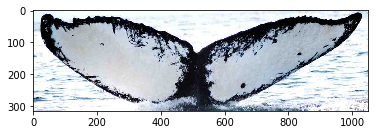

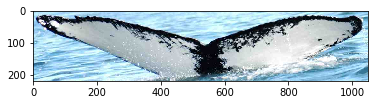

In [16]:
import numpy as np
import random
import ntpath

NUM_PREDICTIONS = 5
NEW_WHALE_TRESHHOLD = 0.9

def getValue(item):
    return item[1]    

train_classes = np.load('train_classes.npy')
final_whale_scores = np.load('final_whale_scores.one-worker.npy')
df_whale_id_2_files = pd.read_csv("train.csv", header = 0)

for_review = [(idx,image_scores) for idx, image_scores in enumerate(final_whale_scores) if NEW_WHALE_TRESHHOLD <= np.amax(image_scores)]
for_review = for_review[:1]
print(f'Reviewing labels of {len(for_review)} top predictions')

# for_review = random.sample(list(enumerate(final_whale_scores)), 3)
# print(f'Reviewing labels of {len(for_review)} random images')

for v in for_review:
    index = v[0]
    scores = v[1]

    print("=" * 100)
    
    file_to_predict = final_generator.filenames[index]
    print(f'Predicting: {file_to_predict}')
    display_image(f'data/final/{file_to_predict}')
    
    print('Top predictions:')
    top_probs = sorted(list(enumerate(scores)), key=getValue, reverse=True)[:NUM_PREDICTIONS]
    print(top_probs)
    
    top_labels = list(map(lambda x: train_classes[x[0]], top_probs))
    max_prob = top_probs[0][1]
    print(f'Original labels: {top_labels}')
    if max_prob < NEW_WHALE_TRESHHOLD:
        top_labels.insert(0, 'new_whale')
        top_labels = top_labels[:NUM_PREDICTIONS]
        print(f'Modified labels: {top_labels}')
     
    predicted_index = top_probs[0][0]
    whale_id = train_classes[predicted_index]
    
    print(f'Predicted index: {predicted_index} whale id: {whale_id}')
    
    print(f'Predictive mean: {np.mean(scores, axis=0)}')
    print(f'Predictive variance: {np.var(scores, axis=0)}')
    print(f'Predictive std: {np.std(scores)}')
    
    for file in df_whale_id_2_files[df_whale_id_2_files.Id == whale_id].Image[:2]:
        display_image(f'./train/{file}')

# Score unlabeled whales and generate a report

In [17]:
import csv
import ntpath
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1. / 255)

final_generator = datagen.flow_from_directory(
    "data/final",
    target_size=target_size,
    batch_size=1,
    class_mode=None, 
    shuffle=False)

NUM_PREDICTIONS = 5
NEW_WHALE_TRESHHOLD = 0.95

def getScore(item):
    return item[1]    

train_classes = np.load('train_classes.npy')
final_whale_scores = np.load('final_whale_scores.one-worker.npy')

with open(f'predictions-{NEW_WHALE_TRESHHOLD}.csv', 'w') as csvfile:
    fieldnames = ['Image', 'Id']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    
    for index, scores in enumerate(final_whale_scores):

        file_to_predict = final_generator.filenames[index]
        top_probs = sorted(list(enumerate(scores)), key=lambda i: i[1], reverse=True)[:NUM_PREDICTIONS]

        top_labels = list(map(lambda x: train_classes[x[0]], top_probs))
        max_prob = top_probs[0][1]
        if max_prob <= NEW_WHALE_TRESHHOLD:
            top_labels.insert(0, 'new_whale')
            top_labels = top_labels[:NUM_PREDICTIONS]
        writer.writerow(dict(zip(fieldnames, [ntpath.basename(file_to_predict), ' '.join(top_labels)])))

Found 15610 images belonging to 1 classes.
